In [1]:
import tensorflow as tf
import numpy as np
from tensorflow_probability import distributions as tfd
from collections import defaultdict
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.append('/content/model')
from model import gp_vae

In [3]:
DATA_DIR="/content/physionet"

!mkdir -p ${DATA_DIR}
!wget https://www.dropbox.com/s/651d86winb4cy9n/physionet.npz?dl=1 -O ${DATA_DIR}/physionet.npz

--2020-12-29 18:31:06--  https://www.dropbox.com/s/651d86winb4cy9n/physionet.npz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/651d86winb4cy9n/physionet.npz [following]
--2020-12-29 18:31:06--  https://www.dropbox.com/s/dl/651d86winb4cy9n/physionet.npz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8a5f0e8d8039073f61541b7db8.dl.dropboxusercontent.com/cd/0/get/BGBst8vn6DtF67c60MspjUWolvIzLeLNN7Hi0TAmQ2rvHPrQkfCxRv6X_GkEKuB3ggc5qH7pHF7lDNIFGlCi_N2HqIELpAcWxZNHZDT9Av_RGauofZxYXCkPC8ZTQNEkvSE/file?dl=1# [following]
--2020-12-29 18:31:07--  https://uc8a5f0e8d8039073f61541b7db8.dl.dropboxusercontent.com/cd/0/get/BGBst8vn6DtF67c60MspjUWolvIzLeLNN7Hi0TAmQ2rvHPrQkfCxRv6X_GkEKuB3ggc5qH7pHF7lDNIFGlCi_N2HqIELpAcWxZNHZDT

In [10]:
DATA_DIR="/content"
SEQ_LENGTH = 48

!mkdir -p ${DATA_DIR}

tickerList = ["AMZN", "GOOG", "AAPL", 
              "MMM", "ABT", "EBAY", 
              "GE", "K", "MAR", "MS", 
              "RTX", "ROK", "BA", 
              "KO", "F", "GLW",
              "MAR", "MSI", "QCOM", "SBUX", 
              "TXN", "TSN", "TSN",
              "VIAC", "CVX", "HSY", "MRK", 
              "PEP", "PG", "HON", 
              "SLB", "GIS", "JNJ", 
              "HPQ", "DIS", "WMT", "T", "VZ", "MSFT"]

start =datetime(1990, 1, 1)
end = datetime(2019, 1, 1)

#data = pdr.DataReader(tickerList, start=start, end=end, data_source="yahoo")
#data.to_pickle(DATA_DIR+"/raw_data.pkl")

data = pd.read_pickle(DATA_DIR+"/raw_data.pkl")
data = data["Adj Close"]#.apply(np.log1p)
data.dropna(axis=1, inplace=True)
#data = data[data.columns[:2]]
#data["BBPL"] = data.values

num_stocks = data.shape[1]

dsplits = np.array([data.to_numpy()[i-SEQ_LENGTH:i] for i in range(SEQ_LENGTH, len(data), SEQ_LENGTH//1)])
scaler = StandardScaler()
dsplits = np.array([scaler.fit_transform(X=d) for d in dsplits])
"""
  Each row in each sample is standard scaled as mean shifts over time -> 
    move this into model __call__() to scale and unscale each batch automatically ?
    Similar to CV models which augment images at training time randomly, perform dropout on per batch basis at training?
"""

mask = []
masked_data = []
clean_data = []

DROP_PCT = 0.5

for d in dsplits:
  #m = np.random.randint(0, 2, size=d.shape)
  #DROP_PCT = np.random.uniform(0.3, 0.8) # Random drop % between 0 and 1
  #m = np.random.choice([0, 1], size=d.shape, p=[DROP_PCT, 1-DROP_PCT])
  m = []
  for _ in range(d.shape[0]): # Different drop % for each stock-series in each sample
    DROP_PCT = np.random.uniform(0.3, 0.8)
    m.append(np.random.choice([0, 1], size=d.shape[1], p=[DROP_PCT, 1-DROP_PCT]))
  m = np.vstack(m)
  mask.append(m)
  masked_data.append(np.array(np.multiply(d, m)))
  clean_data.append(d)

mask = np.array(mask, dtype=np.float32) # Removal mask
masked_data = np.array(masked_data, dtype=np.float32) # Data with values removed
clean_data = np.array(clean_data, dtype=np.float32) # Data without values removed

dtrain, dval, ctrain, cval, mtrain, mval = train_test_split(masked_data, clean_data, mask, test_size=0.2, shuffle=True)


In [ ]:
dtrain

In [45]:
"""
  Params
"""
flags = {}

flags['latent_dim'] = num_stocks # Dimensionality of the latent space
flags['encoder_sizes'] =  [128, 128] # Layer sizes of the encoder
flags['decoder_sizes'] =  [256, 256] # Layer sizes of the decoder
flags['window_size'] =  SEQ_LENGTH//4 # Window size for the inference CNN
flags['sigma'] = 5.005 # Sigma value for the GP prior
flags['length_scale'] =  5.0 # Length scale value for the GP prior
flags['beta'] =  1.0 # Factor to weigh the KL term (similar to beta-VAE)
flags['num_epochs'] = 50 # Number of training epochs

flags['learning_rate'] = 1e-3 # Learning rate for training 
flags['gradient_clip'] = 1e4 # Maximum global gradient norm for the gradient clipping during training
flags['num_steps'] = 0 # Number of training steps: If non-zero it overwrites num_epochs
flags['print_interval'] = 100 # Interval for printing the loss and saving the model during training
flags['exp_name'] =  "test" # Name of the experiment
flags['basedir'] = "/content" # Directory in which the models should be stored
flags['data_dir'] =  "" # Directory from where the data should be read in
flags['seed'] =  7  # Seed for the random number generator
flags['batch_size'] =  64 # 'Batch size for training
flags['paper_version'] =  False # Use paper's version of decoder with variance=1 time series or train model to learn covariance

flags['M'] =  1 # Number of samples for ELBO estimation
flags['K'] = 1 # Number of importance sampling weights

flags['kernel'] = 'cauchy' # ['rbf', 'diffusion', 'matern', 'cauchy'], Kernel to be used for the GP prior
flags['kernel_scales'] = 1 # Number of different length scales sigma for the GP prior

flags['data_dim'] = num_stocks
flags['time_length'] = SEQ_LENGTH
FLAGS = flags

In [46]:
model = gp_vae.GP_VAE(flags)

In [ ]:
data = np.load("/content/$/content/physionet/physionet.npz")
x_train_miss = data['x_train_miss'][:,:,:1].reshape(-1, 48, 1)
m_train_miss = data['m_train_miss'][:,:,:1].reshape(-1, 48, 1)
x_val_miss = data["x_val_miss"][:,:,:1].reshape(-1, 48, 1)
m_val_miss = data["m_val_miss"][:,:,:1].reshape(-1, 48, 1)

#x_train_miss = np.dstack([x_train_miss[:len(dtrain)],dtrain])
#m_train_miss = np.dstack([m_train_miss[:len(mtrain)],mtrain])
#x_val_miss = np.dstack([x_val_miss[:len(dval)],dval])
#m_val_miss = np.dstack([m_val_miss[:len(mval)],mval])

#x_train_miss = np.vstack([x_train_miss[:600], dtrain])
#m_train_miss = np.vstack([m_train_miss[:600], mtrain])
#x_val_miss = np.vstack([x_val_miss[:600], dval])
#m_val_miss = np.vstack([m_val_miss[:600], mval])

tf_x_train_miss = tf.data.Dataset.from_tensor_slices((x_train_miss, m_train_miss)).shuffle(len(x_train_miss)).batch(FLAGS['batch_size']).repeat()
tf_x_val_miss = tf.data.Dataset.from_tensor_slices((x_val_miss, m_val_miss)).batch(FLAGS['batch_size']).repeat()
tf_x_val_miss = tf.compat.v1.data.make_one_shot_iterator(tf_x_val_miss)

In [47]:
tf_x_train_miss = tf.data.Dataset.from_tensor_slices((dtrain, mtrain, ctrain)).shuffle(len(dtrain)).batch(FLAGS['batch_size']).repeat()
tf_x_val_miss = tf.data.Dataset.from_tensor_slices((dval, mval)).batch(FLAGS['batch_size']).repeat()
tf_x_val_miss = tf.compat.v1.data.make_one_shot_iterator(tf_x_val_miss)

print("GPU support: ", tf.config.list_physical_devices('GPU'))
_ = tf.compat.v1.train.get_or_create_global_step()
trainable_vars = model.get_trainable_vars()
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

num_steps = 500 * len(dtrain) // 64 # Number of total training steps

losses_train = []
losses_val = []

t0 = time.time()

for i, (x_seq, m_seq, c_seq) in enumerate(tf_x_train_miss.take(num_steps)):
  # Train on unmissing data
  with tf.GradientTape() as tape:
      tape.watch(trainable_vars)
      loss = model.compute_loss(c_seq)
      losses_train.append(loss.numpy())
  grads = tape.gradient(loss, trainable_vars)
  grads = [np.nan_to_num(grad) for grad in grads]
  grads, global_norm = tf.clip_by_global_norm(grads, 1e4)
  optimizer.apply_gradients(zip(grads, trainable_vars), global_step=tf.compat.v1.train.get_or_create_global_step())

  # Train on missing data
  with tf.GradientTape() as tape:
      tape.watch(trainable_vars)
      loss = model.compute_loss(x_seq)
      losses_train.append(loss.numpy())
  grads = tape.gradient(loss, trainable_vars)
  grads = [np.nan_to_num(grad) for grad in grads]
  grads, global_norm = tf.clip_by_global_norm(grads, 1e4)
  optimizer.apply_gradients(zip(grads, trainable_vars), global_step=tf.compat.v1.train.get_or_create_global_step())

  # Print validation results periodically
  if i % FLAGS['print_interval'] == 0:
      print("================================================")
      print("Learning rate: {} | Global gradient norm: {:.2f}".format(optimizer._lr, global_norm))
      print("Time Elapsed = {:2f}".format(time.time() - t0))
      loss, nll, kl = model.compute_loss(x_seq, m_mask=m_seq, return_parts=True)
      print("Train loss = {:.3f} | NLL = {:.3f} | KL = {:.3f}".format(loss, nll, kl))

      # Validation loss
      x_val_batch, m_val_batch = tf_x_val_miss.get_next()
      val_loss, val_nll, val_kl = model.compute_loss(x_val_batch, m_mask=m_val_batch, return_parts=True)
      losses_val.append(val_loss.numpy())
      print("Validation loss = {:.3f} | NLL = {:.3f} | KL = {:.3f}".format(val_loss, val_nll, val_kl))

print("Complete")

GPU support:  []
Learning rate: 0.001 | Global gradient norm: 39115.18
Time Elapsed = 0.750410
Train loss = 49723.984 | NLL = 705.790 | KL = 49018.195
Validation loss = 49972.480 | NLL = 712.591 | KL = 49259.891
Learning rate: 0.001 | Global gradient norm: 1410.89
Time Elapsed = 53.012667
Train loss = 2279.810 | NLL = 417.361 | KL = 1862.449
Validation loss = 2377.609 | NLL = 418.947 | KL = 1958.663
Learning rate: 0.001 | Global gradient norm: 1258.69
Time Elapsed = 105.965407
Train loss = 2074.226 | NLL = 313.128 | KL = 1761.097
Validation loss = 2087.113 | NLL = 315.363 | KL = 1771.750
Learning rate: 0.001 | Global gradient norm: 807.79
Time Elapsed = 158.597235
Train loss = 2040.370 | NLL = 227.555 | KL = 1812.815
Validation loss = 2057.288 | NLL = 238.530 | KL = 1818.757
Learning rate: 0.001 | Global gradient norm: 1364.40
Time Elapsed = 211.793703
Train loss = 2035.041 | NLL = 174.851 | KL = 1860.189
Validation loss = 2062.038 | NLL = 194.992 | KL = 1867.046
Learning rate: 0.001 |

KeyboardInterrupt: ignored

In [48]:
#t = np.vstack([model.decode(model.encode(x_batch).mean()).mean().numpy() for x_batch in np.array_split(dval, 64, axis=0)])
t = np.vstack([model(x_batch).numpy() for x_batch in np.array_split(dval, 64, axis=0)])
d = np.vstack([x for x in np.array_split(dval, 64, axis=0)])
c = np.vstack([x for x in np.array_split(cval, 64, axis=0)])
#std = np.vstack([model.decode(model.encode(x_batch).mean()).variance().numpy() for x_batch in np.array_split(dval, 64, axis=0)])
std = np.vstack([model(x_batch, with_var=True)[-1].numpy() for x_batch in np.array_split(dval, 64, axis=0)])
#samples = np.array([np.vstack([model.decode(model.encode(x_batch).mean()).sample().numpy() for x_batch in np.array_split(dval, 64, axis=0)]) for _ in range(2)])


In [216]:
t = np.vstack([model.decode(model.encode(x_batch).mean()).mean().numpy() for x_batch in np.array_split(x_val_miss, 64, axis=0)])
d = np.vstack([x for x in np.array_split(x_val_miss, 64, axis=0)])
std = np.vstack([model.decode(model.encode(x_batch).mean()).variance().numpy() for x_batch in np.array_split(x_val_miss, 64, axis=0)])
#samples = np.array([np.vstack([model.decode(model.encode(x_batch).mean()).sample().numpy() for x_batch in np.array_split(x_val_miss, 64, axis=0)]) for _ in range(5)])


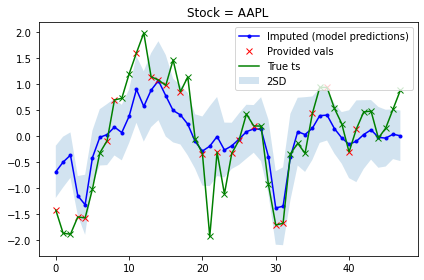

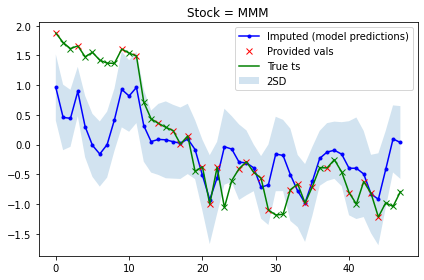

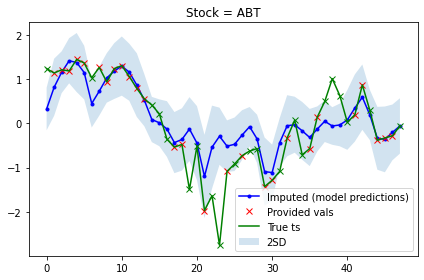

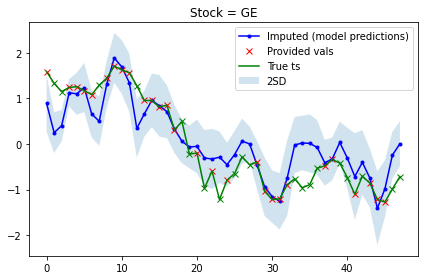

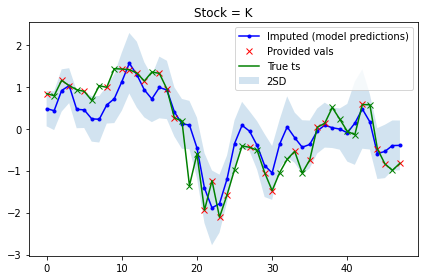

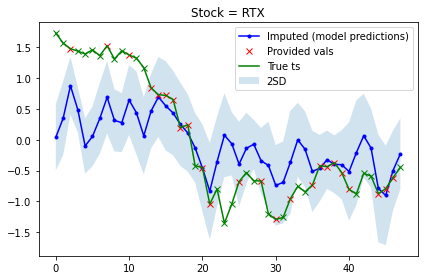

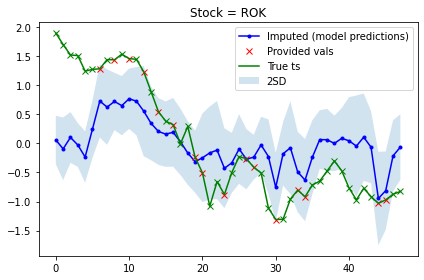

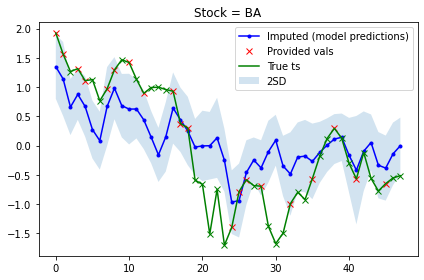

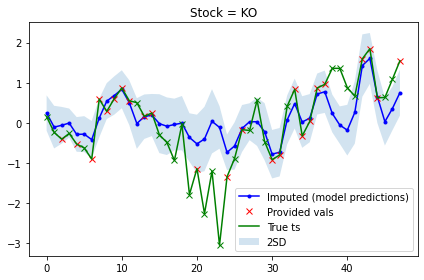

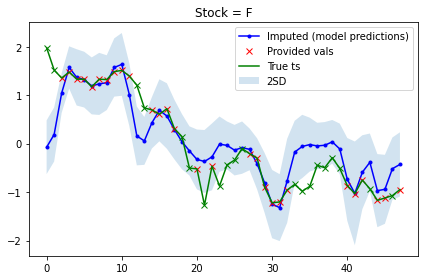

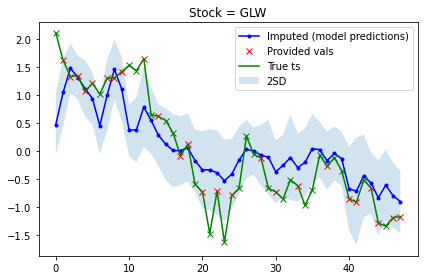

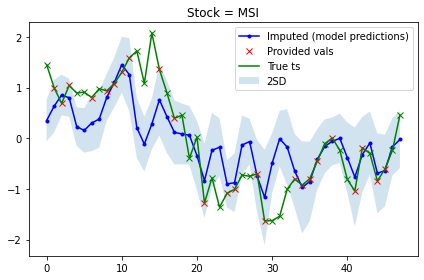

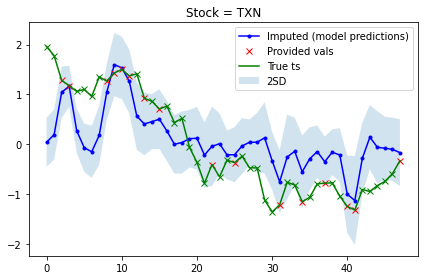

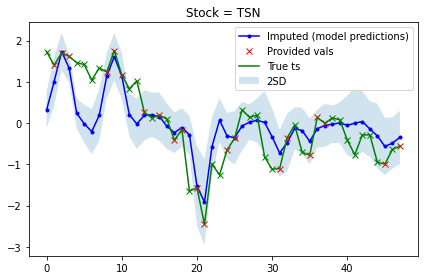

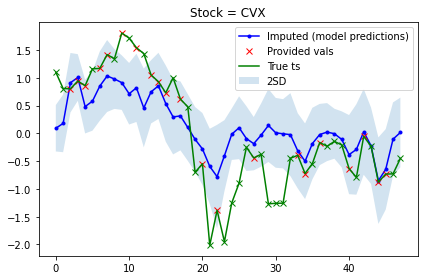

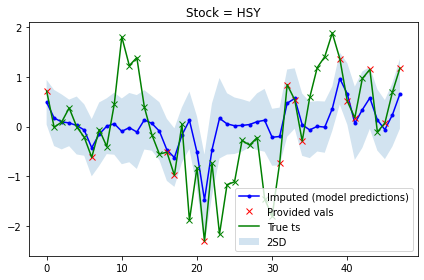

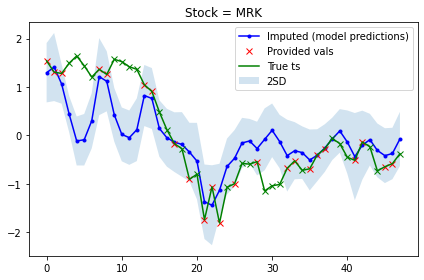

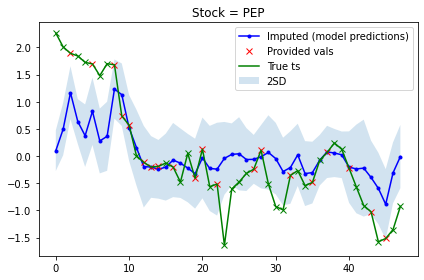

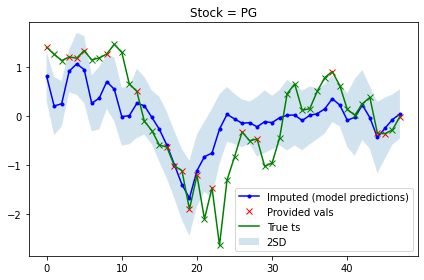

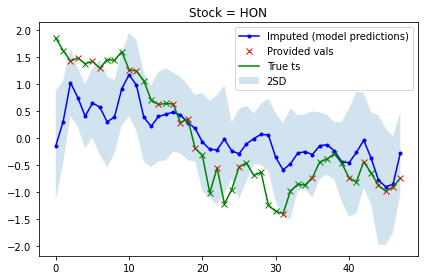

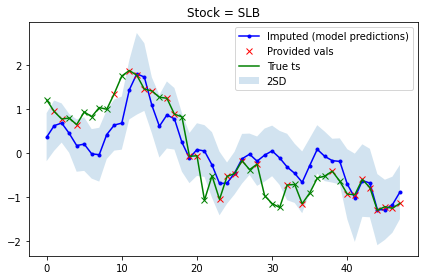

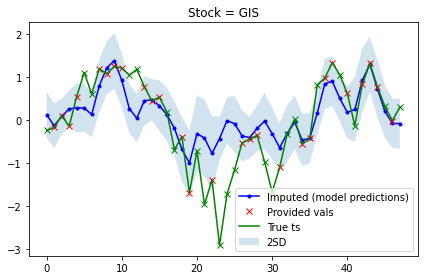

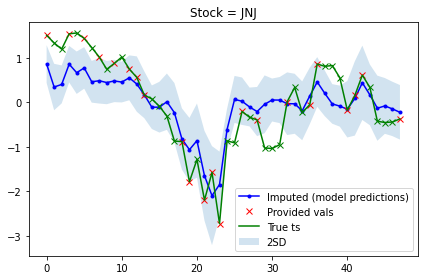

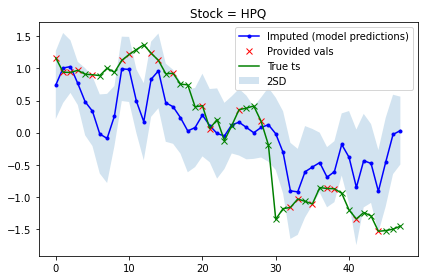

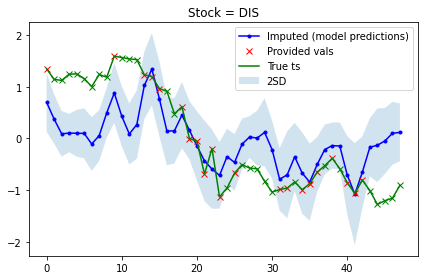

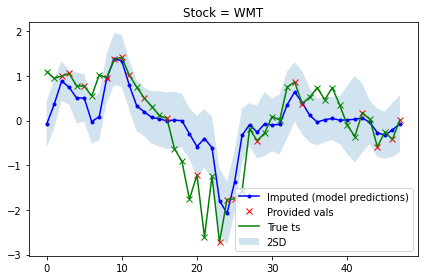

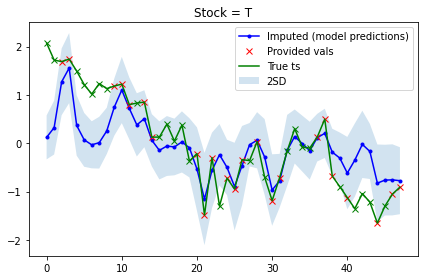

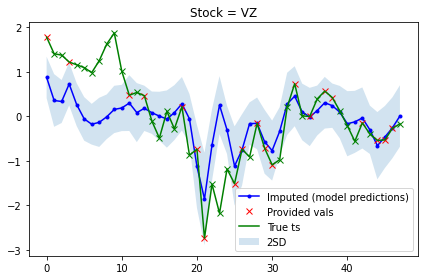

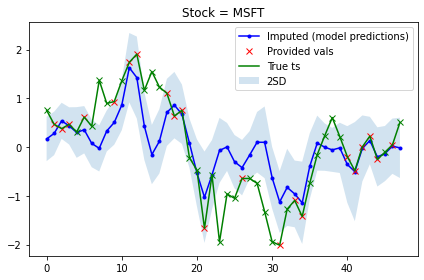

In [49]:
s_num = 1

for xnum, stock in enumerate(data.columns):
  imputed = t[s_num, :, xnum]
  imputed_std = np.sqrt(std[s_num, :, xnum])
  true = d[s_num, :, xnum]
  missing_vals = c[s_num, :, xnum]
  #samps = samples[:, s_num, :, xnum].T
  rep_imputed = [i if x==0 else x for x,i in zip(true, imputed)]

  #plt.plot(samps, ".-g", label="Samples", alpha=0.8)
  plt.plot(imputed, ".-b", label="Imputed (model predictions)")
  #plt.plot(rep_imputed, ".-y", label="Imputed (replaced with known)")
  plt.fill_between(np.arange(0, len(imputed)), imputed+imputed_std*2, imputed-imputed_std*2, alpha=0.2, label="2SD")
  plt.plot([float('nan') if x==0 else x for x in true], "xr", label="Provided vals")
  plt.plot([m if x==0 else float('nan') for x, m in zip(true, missing_vals)], "xg")
  plt.plot(missing_vals, "-g", label="True ts")
  plt.title("Stock = " + str(stock))
  plt.legend()
  plt.tight_layout()
  plt.show()